In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import pandas as pd
import re

import numpy as np

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.metrics import roc_auc_score

import json
import warnings

import numpy as np
import pandas as pd

from category_encoders import OrdinalEncoder
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.svm import SVC
from scipy.stats import uniform
from sklearn.metrics import f1_score, accuracy_score

import matplotlib.pyplot as plt

# New dataset

In [2]:
df_all=pd.read_csv('./x_imputed.csv')
df_all
df_ind=pd.read_csv('./newx.csv')
df_ind

,Unnamed: 0,X,split,state_id,discount,Home_policy_ind,Agent_cd,m_living_status,m_ownership,df_prior_carrier,...,num_loaned_veh,num_owned_veh,num_leased_veh,num_date,driver_age,n_safty_rating,car_age,n_car,lon,lat
0,1,1,Train,NY,1,1,15973623.0,2,0,0,...,1,2,0,1422370800,50,74.0,5.0,2,-73.824262,40.826219
1,2,2,Test,NY,0,0,46978147.0,2,0,3,...,1,1,2,1423666800,56,62.0,3.0,2,-73.647734,43.316389
2,3,3,Train,NY,0,0,32759856.0,2,0,3,...,1,2,1,1535900400,49,70.0,7.0,2,-73.622714,40.815596
3,4,4,Test,FL,0,0,47310293.0,2,0,6,...,2,3,0,1438009200,30,90.0,6.0,2,-80.148441,25.853563
4,5,5,Train,NY,0,0,15675431.0,1,0,2,...,0,1,2,1463497200,56,82.0,4.0,2,-77.556210,43.211053
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49157,49158,49158,Train,FL,1,1,61229929.0,2,0,8,...,2,2,0,1524236400,52,90.0,5.0,2,-82.328911,29.642252
49158,49159,49159,Train,NY,1,1,33958256.0,2,1,5,...,2,2,0,1484060400,69,74.0,6.0,2,-73.588858,40.703365
49159,49160,49160,Train,FL,0,0,92637408.0,0,0,6,...,1,3,1,1519743600,19,39.0,7.0,2,-80.354729,25.990418
49160,49161,49161,Train,NY,1,1,33958256.0,2,1,5,...,2,2,0,1453129200,53,78.0,5.0,3,-73.638904,40.589527


In [3]:
df_train=df_all.drop(list(np.where(df_ind["split"]=="Test")[0]),axis="rows")
df_train=df_train.reset_index()
x_train=df_train.drop(['Unnamed: 0','num_date','index'],axis='columns')
x_train
#convert state_id
uniq_vals=list(set(x_train["state_id"]))
for i in range(len(uniq_vals)):
    x_train["state_id"][x_train["state_id"]==uniq_vals[i]]=i
x_train["state_id"]=pd.Categorical(x_train["state_id"])
#convert discount
x_train["discount"]=pd.Categorical(x_train["discount"])
#convert home_policy
x_train["Home_policy_ind"]=pd.Categorical(x_train["Home_policy_ind"])
#convert Agent_cd
x_train["Agent_cd"]=pd.Categorical(x_train["Agent_cd"])
#convert m_living_status
x_train["m_living_status"]=pd.Categorical(x_train["m_living_status"])
#convert m_ownership
x_train["m_ownership"]=pd.Categorical(x_train["m_ownership"])
#convert df_prior_carrier
x_train["df_prior_carrier"]=pd.Categorical(x_train["df_prior_carrier"])
#convert df_cov_package
x_train["df_cov_package"]=pd.Categorical(x_train["df_cov_package"])
#convert df_cat_zone
x_train["df_cat_zone"]=pd.Categorical(x_train["df_cat_zone"])

/var/folders/py/_t53drj96yg2kvjx55fqy2zh0000gn/T/ipykernel_10335/2463129842.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train["state_id"][x_train["state_id"]==uniq_vals[i]]=i
/Users/jinwen/opt/anaconda3/lib/python3.9/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


In [4]:
y_train=pd.read_csv('./train_y.csv')
y_train=y_train.drop(['Unnamed: 0'],axis='columns')

In [5]:
ind=np.random.randint(low=0,high=5,size=len(x_train))

In [6]:
alfs=np.arange(0.1,0.2,0.1)
for j in alfs:
    auc=[]
    for i in range(5):
        x_train_test=np.asarray(x_train.iloc[np.where(ind==i)[0]])
        x_train_train=np.asarray(x_train.iloc[np.where(ind!=i)[0]])
        y_train_test=np.asarray(y_train.iloc[np.where(ind==i)[0]])
        y_train_train=np.asarray(y_train.iloc[np.where(ind!=i)[0]])
        model = XGBClassifier(reg_alpha=1.2,reg_lambda=1,colsample_bytree=0.4,gamma=0.4,random_state=70, scale_pos_weight=4.5, eval_metric='auc',max_depth=3,learning_rate=0.05,n_estimators=250,min_child_weight=2,subsample=0.6)
    #model=LogisticRegression(penalty="l1",class_weight="balanced",solver="liblinear")
    #model=RandomForestClassifier(criterion='entropy',class_weight="balanced",max_depth=14,n_estimators=50,max_features=7,min_samples_leaf=1)
    #model=CatBoostClassifier(loss_function="CrossEntropy",eval_metric='AUC',depth=8)
        model.fit(x_train_train, y_train_train)
        auc.append(roc_auc_score(y_train_test,model.predict_proba(x_train_test)[:,1]))
    
    print(np.mean(auc))

0.6724276559279616


In [7]:
df_test=df_all.drop(list(np.where(df_ind["split"]=="Train")[0]),axis="rows")
df_test=df_test.reset_index()
df_test
x_test=df_test.drop(['Unnamed: 0','num_date','index'],axis='columns')

#convert state_id
uniq_vals=list(set(x_test["state_id"]))
for i in range(len(uniq_vals)):
    x_test["state_id"][x_test["state_id"]==uniq_vals[i]]=i
x_test["state_id"]=pd.Categorical(x_test["state_id"])
#convert discount
x_test["discount"]=pd.Categorical(x_test["discount"])
#convert home_policy
x_test["Home_policy_ind"]=pd.Categorical(x_test["Home_policy_ind"])
#convert Agent_cd
x_test["Agent_cd"]=pd.Categorical(x_test["Agent_cd"])
#convert m_living_status
x_test["m_living_status"]=pd.Categorical(x_test["m_living_status"])
#convert m_ownership
x_test["m_ownership"]=pd.Categorical(x_test["m_ownership"])
#convert df_prior_carrier
x_test["df_prior_carrier"]=pd.Categorical(x_test["df_prior_carrier"])
#convert df_cov_package
x_test["df_cov_package"]=pd.Categorical(x_test["df_cov_package"])
#convert df_cat_zone
x_test["df_cat_zone"]=pd.Categorical(x_test["df_cat_zone"])

/var/folders/py/_t53drj96yg2kvjx55fqy2zh0000gn/T/ipykernel_10335/3442292878.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test["state_id"][x_test["state_id"]==uniq_vals[i]]=i
/Users/jinwen/opt/anaconda3/lib/python3.9/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


In [8]:
model = XGBClassifier(reg_alpha=1.2,reg_lambda=1,colsample_bytree=0.4,gamma=0.4,random_state=70, scale_pos_weight=4.5, eval_metric='auc',max_depth=3,learning_rate=0.05,n_estimators=250,min_child_weight=2,subsample=0.6)
model.fit(np.array(x_train),np.array(y_train))

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.4,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', feature_types=None, gamma=0.4, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.05, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=3, max_leaves=0, min_child_weight=2, missing=nan,
              monotone_constraints='()', n_estimators=250, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=70, ...)

In [9]:
model.predict_proba(np.array(x_test))[:,1]

array([0.23948649, 0.30698436, 0.15310216, ..., 0.2641228 , 0.30221298,
       0.23820809], dtype=float32)

In [10]:
sum(model.predict(np.array(x_test)))/len(x_test)

0.12049467089740461

In [11]:
y_pred=model.predict_proba(np.array(x_test))[:,1]
df_test_full=pd.read_csv('./test_full1.csv')
dict={'policy_id':list(df_test_full['policy_id']),
     'TARGET':list(y_pred)}
final_csv = pd.DataFrame(dict)
final_csv.to_csv("final2.csv",index=False)

Text(0.5, 0, 'Xgboost Feature Importance')

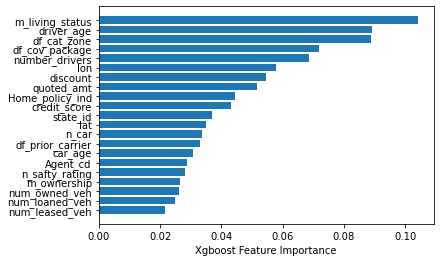

In [12]:
sorted_idx=model.feature_importances_.argsort()
plt.barh((x_train.columns)[sorted_idx],model.feature_importances_[sorted_idx])
plt.xlabel("Xgboost Feature Importance")

In [13]:
?model